In [4]:
import torch
import torch.nn as nn  # object oriented programming
import torch.nn.functional as F  # functions
import torch.optim as optim
import torchvision
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn  # object oriented programming
import torch.nn.functional as F  # functions

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:

#normalization and ToTensor transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#hyper-parameters
batch_size = 4  # 4
EPOCHS = 1  # 7
lr = 0.001  # 0.001
momentum = 0.9 # 0.9

trainset = torchvision.datasets.CIFAR10(root='C:\\Users\\ryans\\OneDrive\\Desktop\\classifiersAgave\\data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                        shuffle=False, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='C:\\Users\\ryans\\OneDrive\\Desktop\\classifiersAgave\\data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [221]:
def imshow(img):
    img = img / 2 + 0.5 #denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


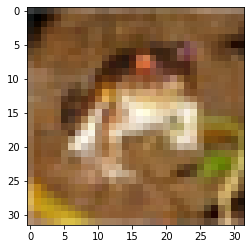

frog


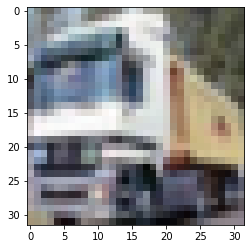

truck


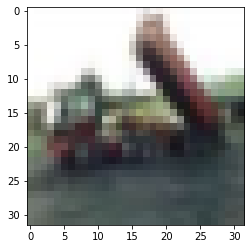

truck


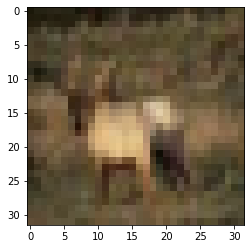

deer


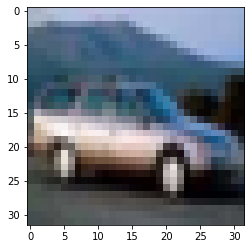

car


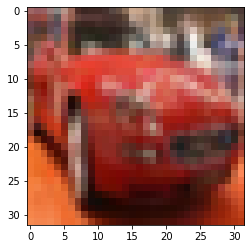

car


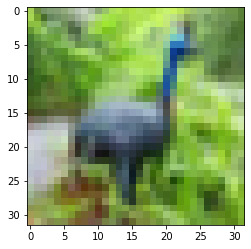

bird


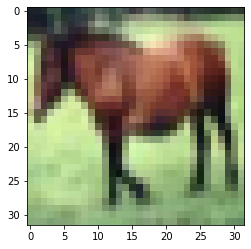

horse


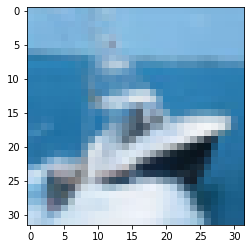

ship


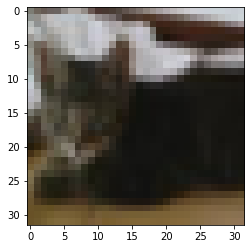

cat


In [222]:
# makes the 2d list of images/labels using the iterater
dataiter = iter(trainloader)
tenImages =[] 
for i in range(10):
    images, labels = dataiter.next()
    tenImages.append([images, labels])
    imshow(torchvision.utils.make_grid(tenImages[i][0]))
    print(classes[tenImages[i][1]])

    

In [223]:
#loads cifar classifier model
class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

model = Net()
model.load_state_dict(torch.load(r"C:\Users\ryans\OneDrive\Desktop\classifiersAgave\cifar_runs\cifar_0.001_10.pth"))
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

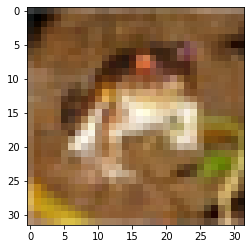

The true tensor index is tensor([6])
The true class is frog
The prediction tensor index is tensor([6])
The predicted class is frog


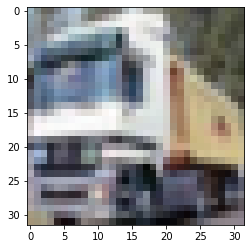

The true tensor index is tensor([9])
The true class is truck
The prediction tensor index is tensor([9])
The predicted class is truck


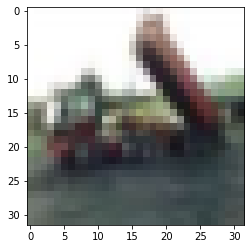

The true tensor index is tensor([9])
The true class is truck
The prediction tensor index is tensor([0])
The predicted class is plane


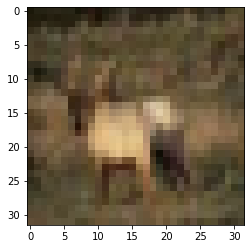

The true tensor index is tensor([4])
The true class is deer
The prediction tensor index is tensor([4])
The predicted class is deer


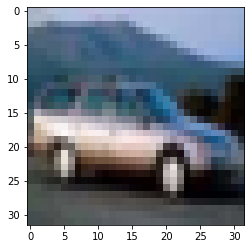

The true tensor index is tensor([1])
The true class is car
The prediction tensor index is tensor([1])
The predicted class is car


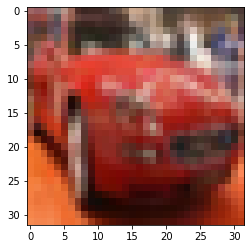

The true tensor index is tensor([1])
The true class is car
The prediction tensor index is tensor([1])
The predicted class is car


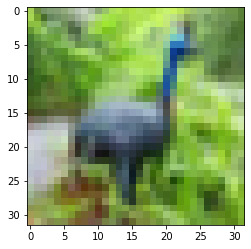

The true tensor index is tensor([2])
The true class is bird
The prediction tensor index is tensor([4])
The predicted class is deer


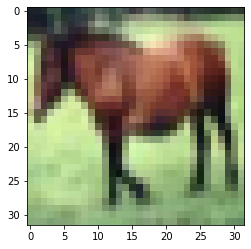

The true tensor index is tensor([7])
The true class is horse
The prediction tensor index is tensor([7])
The predicted class is horse


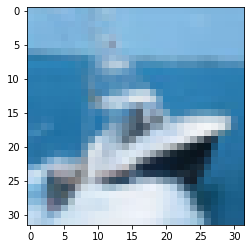

The true tensor index is tensor([8])
The true class is ship
The prediction tensor index is tensor([8])
The predicted class is ship


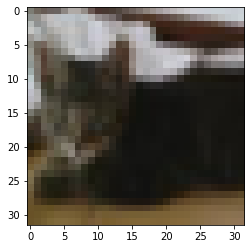

The true tensor index is tensor([3])
The true class is cat
The prediction tensor index is tensor([0])
The predicted class is plane

The accuracy of the model on these images was 70.0%


In [224]:
#passes images through the model and sees the accuracy without the adversarial noise
correct = 0
total = 0

for i,v in tenImages:
    imshow(torchvision.utils.make_grid(i))
    print("The true tensor index is " + str(v))
    print("The true class is " + classes[v.item()])
    tensor, pred_index = torch.max(model(i), 1)
    print("The prediction tensor index is " + str(pred_index))
    print("The predicted class is " + str(classes[pred_index.item()]))
    if pred_index.item() == v.item():
        correct += 1
    total +=1
    
print("\nThe accuracy of the model on these images was " + str((correct / total) * 100) + "%")
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


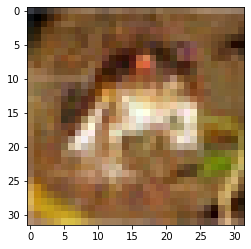

In [225]:
#create the adversarial examples
def perturb(x):
    
    #set bounds for perturbation
    epsilon = 2./32 #used to be 2./255
    #make empty tensor the size of mask_tensor
    delta = torch.zeros_like(x[0], requires_grad=True)
    #optimization method is stochastic gradient descent with respect to the new tensor (learning rate is 0.1)
    opt = optim.SGD([delta], lr=0.1)

    for t in range(30):

        #a prediction is made on normalized mask_tensor + delta
        pred = model(x[0] + delta)
        #loss between model prediction and gasmask class tensor is calculated
        loss = -nn.CrossEntropyLoss()(pred, x[1])
        
        #clears old gradients from the last step
        opt.zero_grad()
        #computes the gradient of the loss with respect to delta
        loss.backward()
        #optimizer steps 0.1 in the direction of the gradient
        opt.step()
        #retains delta between a minimum and maximum perturbation if necessary
        delta.data.clamp_(-epsilon, epsilon)
        
    return x[0] + delta.detach() #returns the attack image
        
imshow(torchvision.utils.make_grid(perturb(tenImages[0])))




Image with no delta is classified as a frog


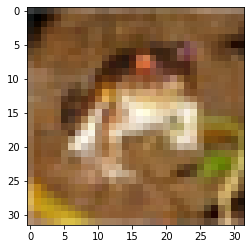

Delta shown below


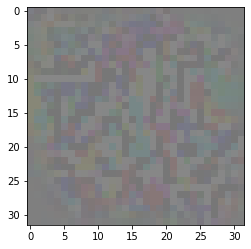

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image plus the delta is classified as a horse


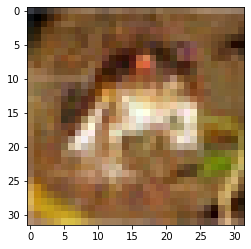

In [226]:

attackImage = perturb(tenImages[0])

#show regular frog and model prediction
tensor, index = torch.max(model(tenImages[0][0]),1)
print("Image with no delta is classified as a " + str(classes[index.item()]))
imshow(torchvision.utils.make_grid(tenImages[0][0]))

#show delta multiplied by 100
print("Delta shown below")
imshow(torchvision.utils.make_grid((attackImage - tenImages[0][0]) ))

#show attack image and model prediction
tensor, index = torch.max(model(attackImage), 1)
print("Image plus the delta is classified as a " + str(classes[index.item()]))
imshow(torchvision.utils.make_grid(attackImage.detach()))



In [227]:
total = 0
correct = 0

#put all of the preturbed images into a 2D list of images and prediction-label-indices
tenAttacks = []
for i,v  in enumerate(tenImages):
    attackImage = perturb(tenImages[i]) 
    _, index = torch.max(model(attackImage), 1)
    tenAttacks.append([attackImage, index])
    
    #tests model accuracy on preturbed predictions
    print(str(tenImages[i][1].item()) + " " + str(classes[tenImages[i][1].item()]))
    print(str(tenAttacks[i][1].item()) + " " + str(classes[tenAttacks[i][1].item()]))
    print()
    if tenAttacks[i][1].item() == tenImages[i][1].item():
        correct += 1
    
    total += 1

print("\nThe accuracy of the model on these perturbed images was " + str((correct / total) * 100) + "%")
    


6 frog
7 horse

9 truck
2 bird

9 truck
2 bird

4 deer
6 frog

1 car
1 car

1 car
5 dog

2 bird
4 deer

7 horse
7 horse

8 ship
0 plane

3 cat
7 horse


The accuracy of the model on these perturbed images was 20.0%
